### **Brain Tumor Detection on YOLOvX App**

In this experiment, we present Brain Tumor - Object Detection using YOLOv9s from @ultralytics, trained on a dataset from Kaggle, with the model shared and deployed on YOLOvX. 🚀

### Install necessary packages

In [2]:
!pip install ultralytics
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117





















































Note: you may need to restart the kernel to use updated packages.

Looking in indexes: https://download.pytorch.org/whl/cu117


























Note: you may need to restart the kernel to use updated packages.


### Check GPU Availability

Make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems navigate to Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save.

In [3]:
!nvidia-smi

Tue Sep 24 11:54:34 2024       

+---------------------------------------------------------------------------------------+

| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |

|-----------------------------------------+----------------------+----------------------+

| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |

| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |

|                                         |                      |               MIG M. |

|=========================================+======================+======================|

|   0  NVIDIA GeForce RTX 3050 ...    On  | 00000000:01:00.0 Off |                  N/A |

| N/A   42C    P0              11W /  60W |     27MiB /  4096MiB |      0%      Default |

|                                         |                      |                  N/A |

+-----------------------------------------+--------------

### Check GPU availability and PyTorch version

In [4]:
import torch

# Check the version of PyTorch and if CUDA is available
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.4.1+cu118

CUDA available: True


### Import libraries

In [5]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import os
import shutil
import random
import torch
from IPython.display import Image

# Set the CUDA device to GPU 0 if available
if torch.cuda.is_available():
    torch.cuda.set_device(0)  # Optional: sets the active GPU (if you have multiple)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Load the YOLO model and move it to the chosen device (GPU or CPU)
model = YOLO('/kaggle/input/yolo-weights/yolov9s.pt', task='detect').to(device)


Using device: cuda



100%|██████████| 14.7M/14.7M [00:00<00:00, 19.5MB/s]


### Managing Files

In [6]:
#clear and recreate dataset folders
if os.path.exists('dataset'):
    shutil.rmtree('dataset')

os.makedirs('dataset/images/train')
os.makedirs('dataset/labels/train')
os.makedirs('dataset/images/test')
os.makedirs('dataset/labels/test')

#copy files from different data sources
data_folders = {
    'axial_t1wce_2_class',
    'coronal_t1wce_2_class',
    'sagittal_t1wce_2_class'
}

for folder in data_folders:
    images_train_path = f'/kaggle/input/brain-tumor-object-detection-datasets/{folder}/images/train'
    labels_train_path = f'/kaggle/input/brain-tumor-object-detection-datasets/{folder}/labels/train'
    images_test_path = f'/kaggle/input/brain-tumor-object-detection-datasets/{folder}/images/test'
    labels_test_path = f'/kaggle/input/brain-tumor-object-detection-datasets/{folder}/labels/test'

    #copy the labels and images if the images have a label
    images_train_files = os.listdir(images_train_path)
    for file in images_train_files:
        filename = os.path.splitext(file)[0]
        label_file_path = os.path.join(labels_train_path, f'{filename}.txt')
        if os.path.exists(label_file_path):
            shutil.copy(os.path.join(images_train_path, f'{filename}.jpg'),
                        os.path.join('dataset/images/train',f'{filename}.jpg'))
            shutil.copy(label_file_path,
                        os.path.join('dataset/labels/train',f'{filename}.txt'))
            
    images_test_files = os.listdir(images_test_path)
    for file in images_test_files:
        filename = os.path.splitext(file)[0]
        label_file_path = os.path.join(labels_test_path, f'{filename}.txt')
        if os.path.exists(label_file_path):
            shutil.copy(os.path.join(images_test_path, f'{filename}.jpg'),
                        os.path.join('dataset/images/test',f'{filename}.jpg'))
            shutil.copy(label_file_path,
                        os.path.join('dataset/labels/test',f'{filename}.txt'))
            

### Visualization

Displaying some training images :


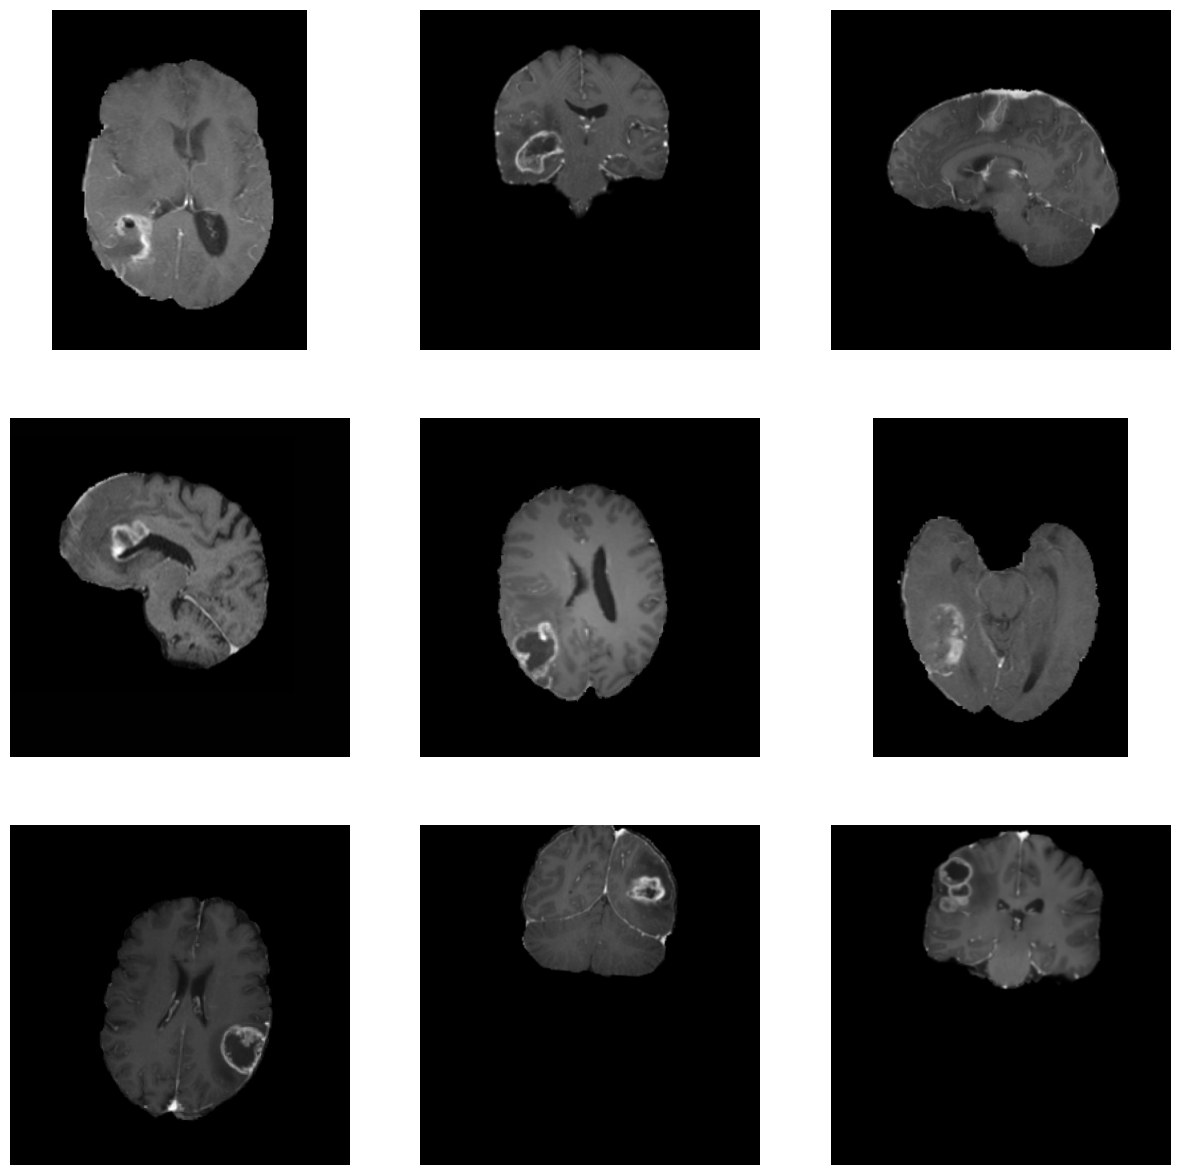

In [7]:

#function to display images
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15,15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        #if it its rgb foto
        #img_rgb = cv2cvtColor(img, cv2.COLOR_BGR2RGB)
        #if it is grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

print("Displaying some training images :")
display_images(os.path.join('dataset', 'images/train'))

In [9]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')


num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)


print("number of images at train: ",num_train_images)
print("number of labels at train: ",num_train_labels)
print("number of images at test: ",num_test_images)
print("number of labels at test: ",num_test_labels)

number of images at train:  878

number of labels at train:  878

number of images at test:  223

number of labels at test:  223


### Split the dataset into training and validation

In [10]:
def move_files(source_dir, target_dir, file_list):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file in file_list:
        source_path = os.path.join(source_dir, file)
        target_path = os.path.join(target_dir, file)
        shutil.move(source_path, target_path)
def count_files(image_dir, label_dir):
    num_images = len(os.listdir(image_dir))
    num_labels = len(os.listdir(label_dir))
    return num_images, num_labels

train_images_path = 'dataset/images/train'
train_labels_path = 'dataset/labels/train'

train_images = os.listdir(train_images_path)

val_split = int(len(train_images)*0.2)
val_images = random.sample(train_images, val_split)

val_images_path = 'dataset/images/val'
val_labels_path = 'dataset/labels/val'

move_files(train_images_path, val_images_path, val_images)

val_labels = [os.path.splitext(image)[0] + '.txt' for image in val_images]

move_files(train_labels_path, val_labels_path, val_labels)

num_train_images, num_train_labels = count_files(train_images_path, train_labels_path)
print(f"number of images at train after split: {num_train_images}")
print(f"number of labels at train after split: {num_train_labels}")

num_val_images, num_val_labels = count_files(val_images_path, val_labels_path)
print(f"number of images at val after split: {num_val_images}")
print(f"number of labels at val after split: {num_val_labels}")

number of images at train after split: 703

number of labels at train after split: 703

number of images at val after split: 175

number of labels at val after split: 175


### Create the YAML configuration file

In [11]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("dataset/fixed_path.yaml", 'w') as file:
    file.write(text)

### Training

In [12]:
# Define paths
yaml_file = f'dataset/fixed_path.yaml'

# Load the YOLO model (use the correct model version/path)
model = YOLO('yolov9s.pt')

# Train the model
results = model.train(data=yaml_file, epochs=100, imgsz=640, batch=4, plots=True)


Ultralytics YOLOv8.2.98 🚀 Python-3.9.19 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3694MiB)

engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=/home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/fixed_path.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=F

100%|██████████| 6.25M/6.25M [00:00<00:00, 16.7MB/s]


AMP: checks passed ✅


train: Scanning /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/labels/train... 703 images, 0 backgrounds, 0 corrupt: 100%|██████████| 703/703 [00:00<00:00, 2924.31it/s]

train: New cache created: /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/sinem/miniconda3/envs/brain_tumor/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.

  check_for_updates()

val: Scanning /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/labels/val... 175 images, 0 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<00:00, 1377.66it/s]

val: New cache created: /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 

optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)

Image sizes 640 train, 640 val

Using 8 dataloader workers

Logging results to runs/detect/train

Starting training for 100 epochs...



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.41G      1.389      4.554      1.312          5        640: 100%|██████████| 176/176 [00:23<00:00,  7.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.76it/s]

                   all        175        184       0.43      0.757      0.461      0.272




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.47G      1.337      1.812      1.264          7        640: 100%|██████████| 176/176 [00:22<00:00,  7.97it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.66it/s]

                   all        175        184       0.42      0.705      0.444      0.307




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.41G      1.295      1.588      1.278          9        640: 100%|██████████| 176/176 [00:22<00:00,  8.00it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]

                   all        175        184      0.347      0.388      0.301      0.184




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.42G      1.321      1.666      1.275          4        640: 100%|██████████| 176/176 [00:21<00:00,  8.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.26it/s]

                   all        175        184      0.439      0.772      0.468      0.315




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.47G      1.289      1.564       1.28          3        640: 100%|██████████| 176/176 [00:21<00:00,  8.08it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.27it/s]

                   all        175        184      0.422      0.749      0.478      0.311




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.46G       1.24      1.422      1.231          8        640: 100%|██████████| 176/176 [00:21<00:00,  8.08it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]

                   all        175        184      0.479       0.72      0.476       0.33




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.45G      1.242       1.46      1.229          5        640: 100%|██████████| 176/176 [00:25<00:00,  6.92it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.64it/s]

                   all        175        184      0.403      0.749      0.428      0.262




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.47G      1.209      1.425      1.209          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.69it/s]

                   all        175        184      0.458      0.826      0.478      0.326




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.46G      1.169      1.351      1.204          2        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]

                   all        175        184      0.462       0.82      0.478      0.325




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.47G       1.21      1.353      1.239          9        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.75it/s]

                   all        175        184      0.469      0.829      0.502      0.355




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.47G      1.152      1.322      1.205          2        640: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.79it/s]

                   all        175        184      0.472      0.851      0.498      0.343




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.46G      1.174      1.316      1.219          9        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184      0.463      0.768      0.476       0.33




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.47G      1.155      1.289      1.209         11        640: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.79it/s]

                   all        175        184      0.486       0.79      0.514      0.345




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.47G      1.127      1.262      1.203          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184       0.46      0.771      0.495      0.348




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.47G      1.109       1.31      1.186          6        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184       0.44      0.804      0.488      0.349




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.47G      1.067      1.218      1.161          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.67it/s]

                   all        175        184      0.462      0.761      0.488      0.334




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.47G       1.17        1.3      1.209          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.456      0.821      0.487      0.346




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.47G      1.127      1.235      1.189          2        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]

                   all        175        184      0.462      0.786      0.547      0.371




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.47G      1.109      1.223      1.185          1        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.74it/s]

                   all        175        184      0.488      0.803      0.496      0.345




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.47G      1.075      1.262      1.163          9        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.71it/s]

                   all        175        184      0.451       0.86      0.525      0.354




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.47G      1.103      1.229      1.169          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.75it/s]

                   all        175        184      0.456      0.848      0.506       0.36




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.46G       1.08      1.197      1.146          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]

                   all        175        184      0.477      0.846       0.55      0.368




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.47G       1.07      1.193      1.167          5        640: 100%|██████████| 176/176 [00:21<00:00,  8.12it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.31it/s]

                   all        175        184      0.503      0.801      0.519      0.355




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.47G      1.028      1.144      1.128          5        640: 100%|██████████| 176/176 [00:21<00:00,  8.11it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.26it/s]

                   all        175        184      0.485       0.85      0.548      0.384




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.47G      1.078      1.155      1.158          4        640: 100%|██████████| 176/176 [00:21<00:00,  8.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.26it/s]

                   all        175        184       0.48       0.87      0.535      0.377




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.47G      1.069      1.165       1.15          7        640: 100%|██████████| 176/176 [00:21<00:00,  8.09it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.29it/s]

                   all        175        184      0.478      0.875      0.531      0.375




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.47G      1.045      1.114      1.132          7        640: 100%|██████████| 176/176 [00:24<00:00,  7.20it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.64it/s]

                   all        175        184      0.491      0.858       0.55      0.383




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.47G      1.021      1.101      1.143          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.34it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.483      0.821      0.553      0.389




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.47G      1.025      1.107      1.136          2        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.69it/s]

                   all        175        184      0.472      0.921      0.551      0.396




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.47G      1.006      1.121      1.129          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.78it/s]

                   all        175        184       0.46       0.82       0.51      0.365




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.47G     0.9966      1.123       1.12          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.452      0.878      0.551       0.39




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.47G     0.9932       1.09      1.122          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.474      0.837      0.545      0.379




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.47G     0.9425      1.084      1.117          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.71it/s]

                   all        175        184      0.479      0.775      0.515      0.385




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.47G      0.965      1.083      1.121          8        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184      0.481      0.855      0.552      0.402




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.47G     0.9587      1.076      1.099          0        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184      0.474       0.86      0.563      0.393




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.47G     0.9456      1.101      1.116          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.81it/s]

                   all        175        184      0.502      0.794      0.574      0.405




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.47G     0.9542      1.097      1.122          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184      0.496      0.793      0.544      0.395




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.47G     0.9428      1.068      1.114          6        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184      0.487      0.863      0.581      0.419




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.47G     0.9499      1.058      1.101          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.81it/s]

                   all        175        184       0.49      0.829      0.582      0.415




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.47G      0.944      1.073      1.115          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.82it/s]

                   all        175        184      0.471      0.875      0.606      0.431




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.47G     0.9301      1.042      1.093          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.80it/s]

                   all        175        184      0.477       0.84      0.591       0.43




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.47G      0.929      1.061      1.083          8        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.79it/s]

                   all        175        184      0.457      0.888      0.574      0.415




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.47G     0.9668       1.08      1.113          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.71it/s]

                   all        175        184      0.471      0.773      0.584      0.418




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.46G     0.9486      1.042      1.098          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.83it/s]

                   all        175        184      0.459      0.888      0.579      0.406




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.47G     0.9405      1.039      1.105          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.83it/s]

                   all        175        184      0.501      0.818      0.598      0.436




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.47G     0.9529     0.9981      1.097          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.74it/s]

                   all        175        184      0.443      0.871       0.58      0.413




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.47G     0.9197      1.049        1.1          4        640: 100%|██████████| 176/176 [00:28<00:00,  6.27it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.68it/s]

                   all        175        184      0.472      0.877      0.575      0.422




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.47G     0.8994      1.019      1.074          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.71it/s]

                   all        175        184      0.493      0.813      0.599      0.422




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.47G     0.9103      1.015      1.081          6        640: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.64it/s]

                   all        175        184      0.462      0.919      0.582      0.409




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.47G     0.8931     0.9991      1.071          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.62it/s]

                   all        175        184      0.501      0.802      0.621      0.453




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.47G     0.8838     0.9999      1.075          2        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.66it/s]

                   all        175        184      0.522      0.828      0.652      0.455




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.46G     0.8775     0.9903      1.051          6        640: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.70it/s]

                   all        175        184      0.486      0.853      0.608      0.434




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.47G     0.9124     0.9916      1.088          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.497      0.846       0.65      0.459




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.47G     0.9034     0.9688       1.07          8        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.61it/s]

                   all        175        184      0.537      0.754      0.639      0.451




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.47G     0.8701      0.961      1.051          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.66it/s]

                   all        175        184      0.504       0.83      0.633      0.454




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.47G     0.8477     0.9557      1.036          8        640: 100%|██████████| 176/176 [00:27<00:00,  6.29it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.64it/s]

                   all        175        184      0.539      0.779      0.668        0.5




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.47G     0.8837     0.9513      1.076          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.33it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.515      0.787      0.664      0.475




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.47G     0.8698     0.9388      1.065          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.70it/s]

                   all        175        184       0.52      0.825      0.672      0.494




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.47G     0.8461     0.9348      1.041          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.67it/s]

                   all        175        184      0.495      0.852      0.646      0.466




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.47G     0.8816     0.9745      1.069          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.75it/s]

                   all        175        184      0.541      0.752      0.635      0.466




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.47G     0.8624     0.9522      1.046          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.68it/s]

                   all        175        184      0.537      0.833      0.651      0.467




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.47G     0.8491     0.9446      1.052          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.34it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.70it/s]

                   all        175        184      0.539      0.801      0.707       0.51




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.47G     0.8142     0.9138      1.041          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.553      0.802      0.697      0.511




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.47G     0.8177     0.8832      1.034          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.556      0.768      0.706      0.516




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.47G     0.8063     0.8866      1.033          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.53it/s]

                   all        175        184      0.592      0.737        0.7      0.504




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.47G     0.8387     0.9332      1.056          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.66it/s]

                   all        175        184      0.627      0.766      0.726      0.527




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.47G     0.8234     0.8949      1.023          8        640: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.38it/s]

                   all        175        184      0.624      0.725      0.749      0.544




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.47G     0.8137     0.8623      1.039          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.644       0.74       0.73      0.531




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.46G     0.8193     0.8978      1.036          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.73it/s]

                   all        175        184      0.563      0.806      0.689      0.503




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.47G     0.8053     0.8543      1.047          2        640: 100%|██████████| 176/176 [00:27<00:00,  6.36it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.70it/s]

                   all        175        184      0.626      0.747      0.698      0.499




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.47G     0.8161     0.8598      1.049          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.34it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.51it/s]

                   all        175        184      0.574       0.75      0.708      0.521




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.47G     0.7946     0.8177      1.034          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.34it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.73it/s]

                   all        175        184      0.564      0.819      0.723      0.547




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.47G     0.7961     0.8205      1.041          5        640: 100%|██████████| 176/176 [00:22<00:00,  7.74it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.25it/s]

                   all        175        184      0.643      0.748      0.736      0.551




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.47G     0.7937     0.8368      1.036          4        640: 100%|██████████| 176/176 [00:22<00:00,  8.00it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.27it/s]

                   all        175        184      0.568      0.826      0.716      0.532




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.47G     0.7934     0.7987      1.021          6        640: 100%|██████████| 176/176 [00:21<00:00,  8.04it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.30it/s]

                   all        175        184      0.585      0.781      0.741      0.547




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.47G      0.773     0.8127      1.021          6        640: 100%|██████████| 176/176 [00:21<00:00,  8.07it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.23it/s]

                   all        175        184      0.605      0.781      0.749      0.548




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.47G     0.7769     0.7912      1.014          6        640: 100%|██████████| 176/176 [00:26<00:00,  6.62it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.66it/s]

                   all        175        184      0.664      0.693      0.741      0.542




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.47G     0.7701     0.7722      1.028          5        640: 100%|██████████| 176/176 [00:28<00:00,  6.26it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.68it/s]

                   all        175        184      0.593      0.786      0.745      0.541




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.46G     0.7694      0.759      1.019          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.72it/s]

                   all        175        184      0.637       0.75      0.752      0.548




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.47G     0.7393      0.716     0.9962          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.33it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.71it/s]

                   all        175        184      0.622      0.839      0.785      0.596




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.47G      0.763      0.774      1.015          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.75it/s]

                   all        175        184      0.607      0.777      0.753      0.571




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.47G     0.7582      0.735      1.009          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.75it/s]

                   all        175        184      0.673      0.732      0.762      0.558




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.47G     0.7666     0.7116      1.022          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]

                   all        175        184      0.674      0.728       0.77      0.567




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.47G     0.7437     0.7593      1.013          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.633      0.796      0.782       0.57




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.47G     0.7443     0.7396      1.004          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.78it/s]

                   all        175        184      0.661      0.753      0.756      0.556




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.47G     0.7486     0.6982       1.01          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.606      0.792      0.757      0.569




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.46G     0.7498     0.7107     0.9923          6        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.673      0.759      0.787      0.589




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.47G     0.6932     0.6593     0.9716          7        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.64it/s]

                   all        175        184      0.702        0.7      0.774      0.582




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.47G     0.7238     0.6498      0.977          5        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.626      0.784      0.759      0.575




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.46G     0.7195     0.6659     0.9893          1        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]

                   all        175        184      0.707      0.672      0.758       0.57


Closing dataloader mosaic

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.46G     0.6493     0.6182     0.9419          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.722      0.735       0.79      0.587




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.46G      0.651     0.5614     0.9347          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184       0.65      0.795      0.791      0.592




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.46G     0.6276     0.5285      0.935          4        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.76it/s]

                   all        175        184      0.641       0.77      0.785      0.593




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.46G     0.6355     0.5237     0.9448          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.71it/s]

                   all        175        184      0.763      0.662      0.783      0.595




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.46G     0.6199     0.5147     0.9398          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.67it/s]

                   all        175        184       0.66      0.779      0.784      0.582




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.46G     0.6149     0.4942     0.9255          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.39it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.75it/s]

                   all        175        184      0.642      0.787      0.775       0.58




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.46G     0.6003     0.4921     0.9201          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.78it/s]

                   all        175        184      0.658      0.759      0.771      0.585




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.46G     0.6066     0.4736      0.928          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.749      0.707      0.777      0.586




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.46G     0.6136     0.4626     0.9245          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.78it/s]

                   all        175        184      0.726      0.717      0.776      0.584




      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.46G     0.5885     0.4495     0.9206          3        640: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.77it/s]

                   all        175        184      0.695      0.752      0.779      0.586




100 epochs completed in 0.818 hours.

Optimizer stripped from runs/detect/train/weights/last.pt, 15.2MB

Optimizer stripped from runs/detect/train/weights/best.pt, 15.2MB



Validating runs/detect/train/weights/best.pt...

Ultralytics YOLOv8.2.98 🚀 Python-3.9.19 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3694MiB)

YOLOv9s summary (fused): 486 layers, 7,167,862 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.73it/s]


                   all        175        184      0.622      0.839      0.785      0.596

              negative         81         85      0.626      0.859       0.79      0.602

              positive         94         99      0.618      0.818       0.78       0.59

Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.4ms postprocess per image

Results saved to runs/detect/train


### Results

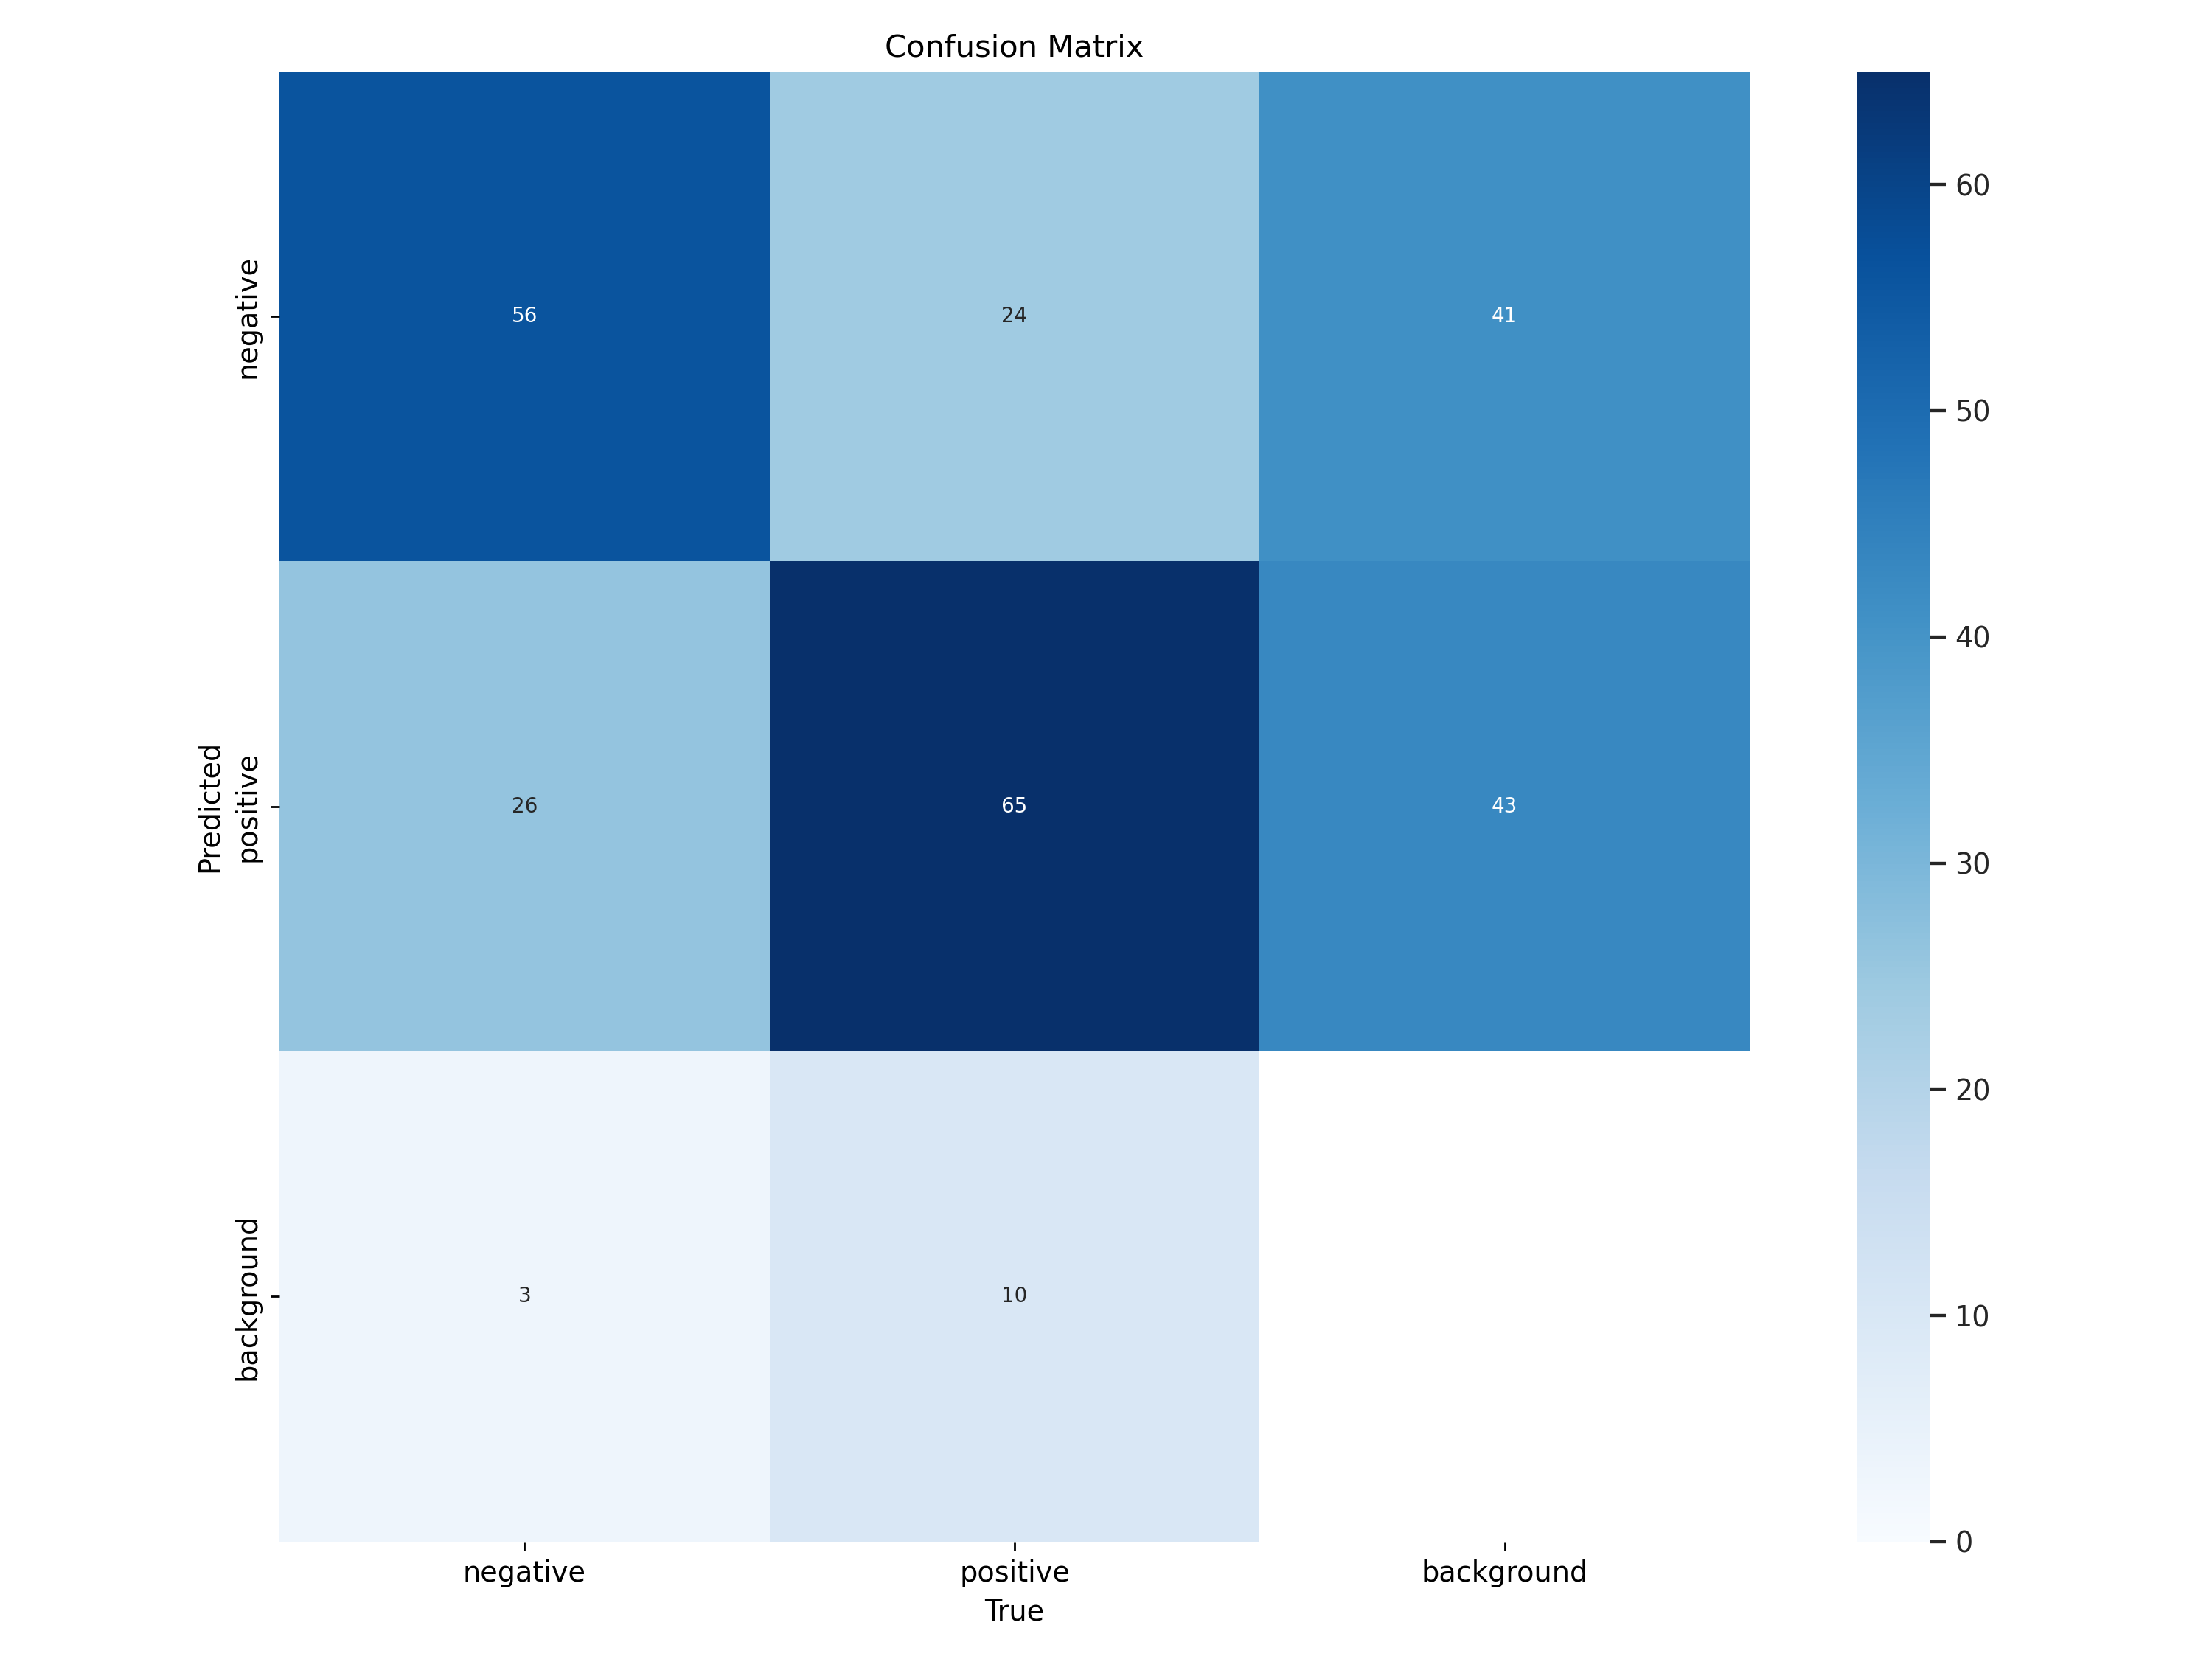

In [13]:
Image(filename=f'runs/detect/train/confusion_matrix.png')

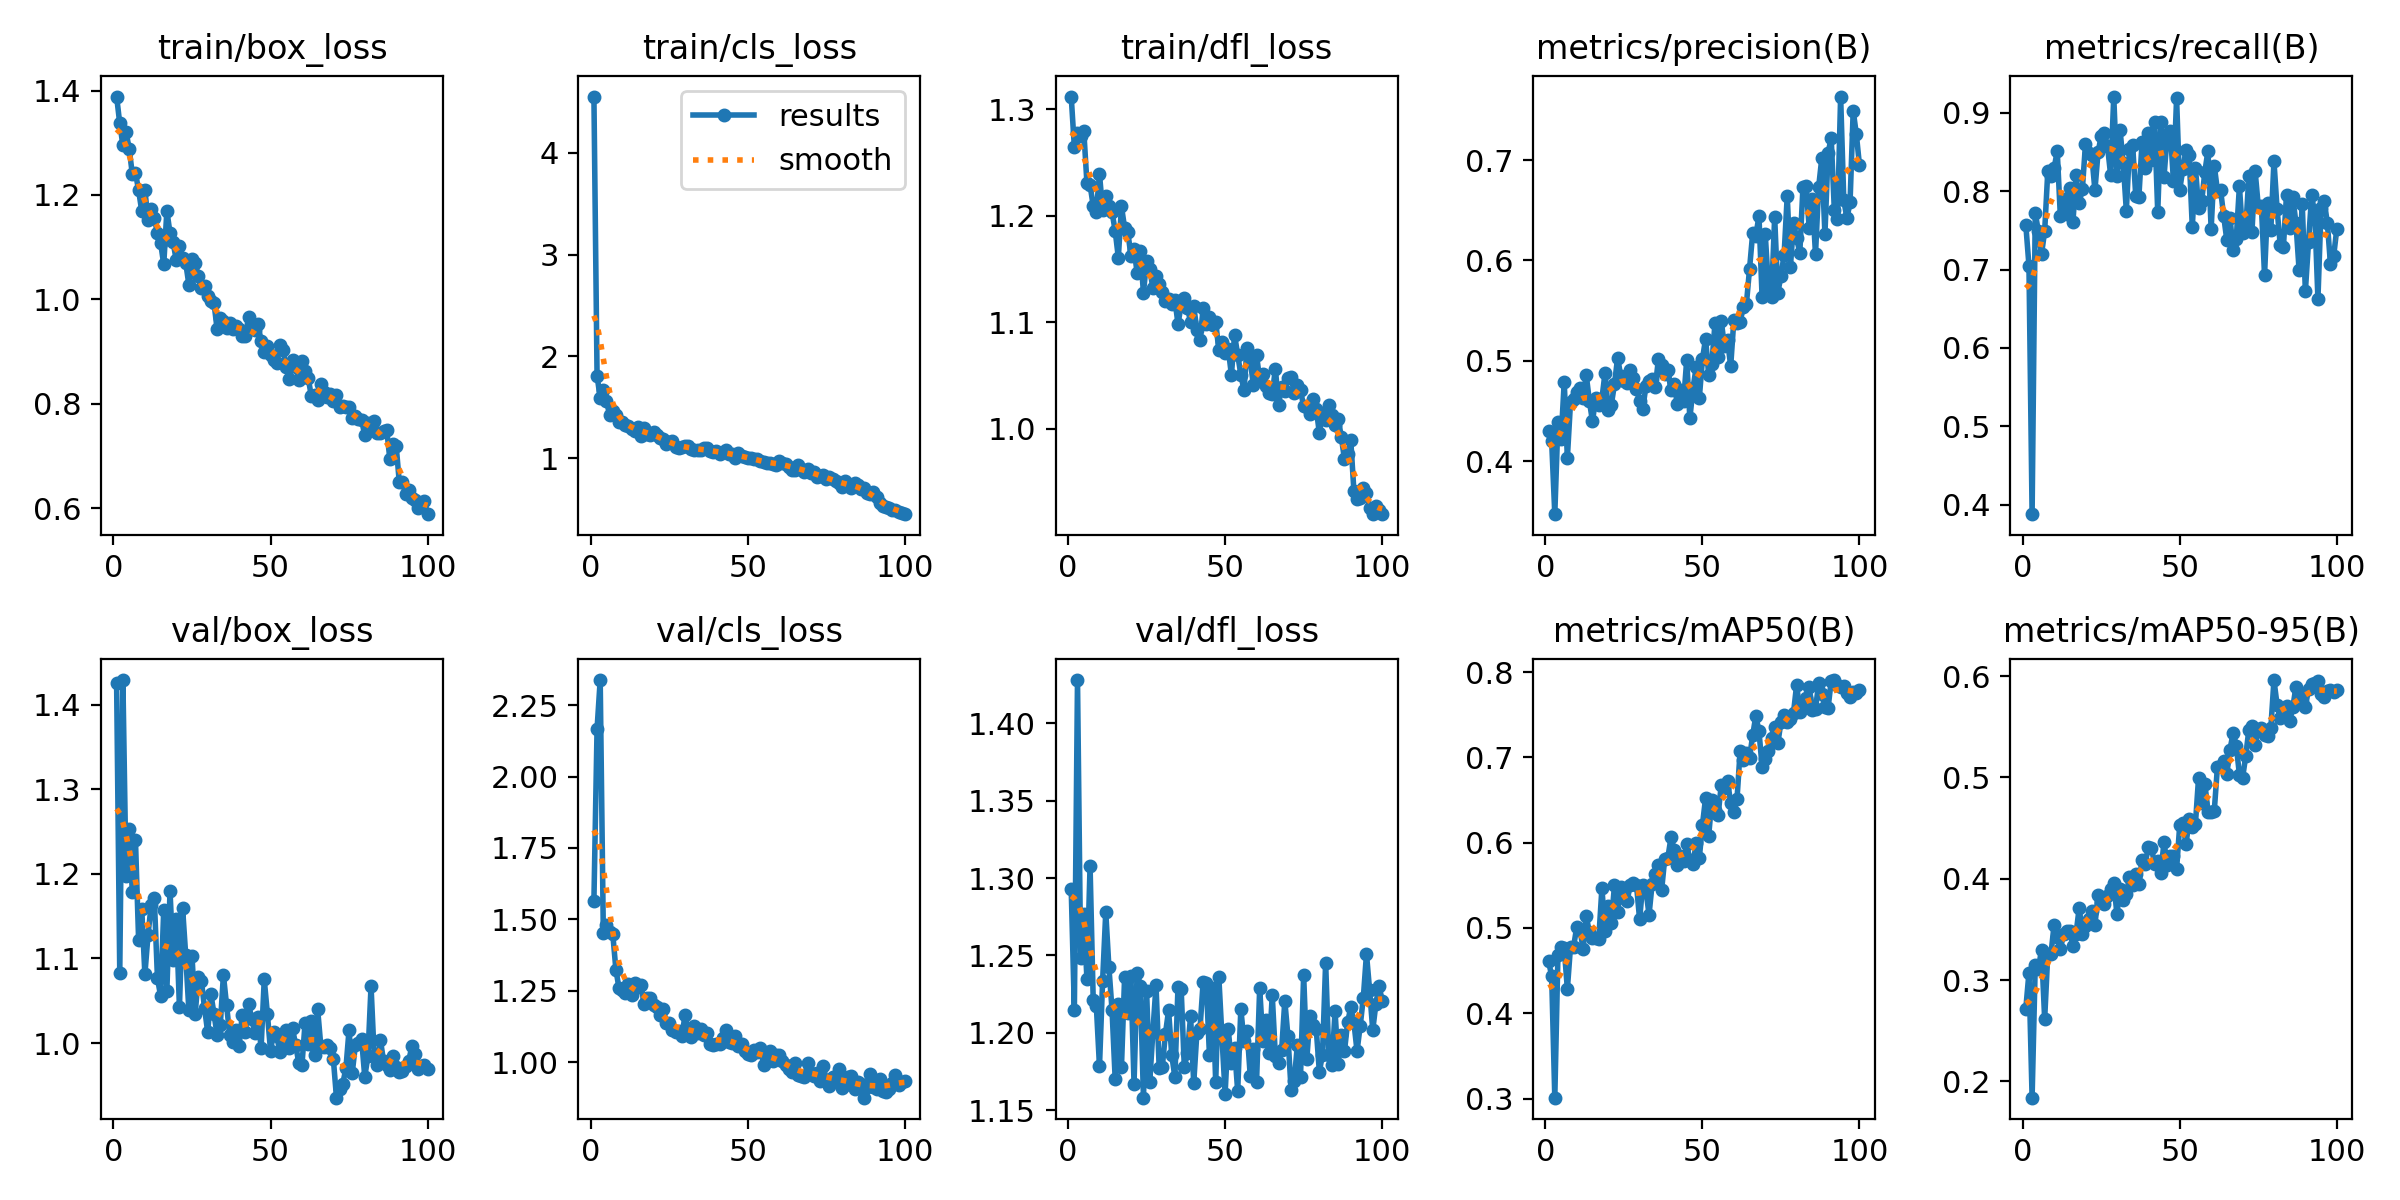

In [14]:
Image(filename=f'runs/detect/train/results.png')

### Evaluate the Model

Displaying results from the brain tumor detection model:



image 1/1 /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/images/test/00053_269.jpg: 640x640 1 negative, 1 positive, 15.1ms

Speed: 1.6ms preprocess, 15.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


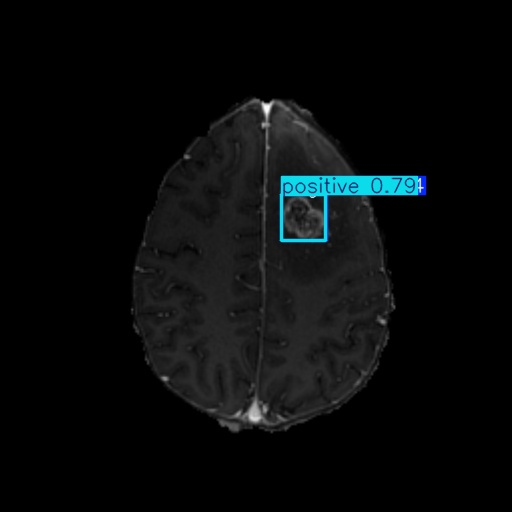



image 1/1 /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/images/test/15.jpg: 640x640 1 positive, 15.1ms

Speed: 1.4ms preprocess, 15.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


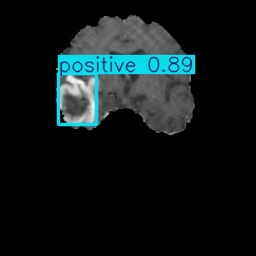



image 1/1 /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/images/test/60 (11).jpg: 640x640 1 negative, 1 positive, 15.1ms

Speed: 1.6ms preprocess, 15.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


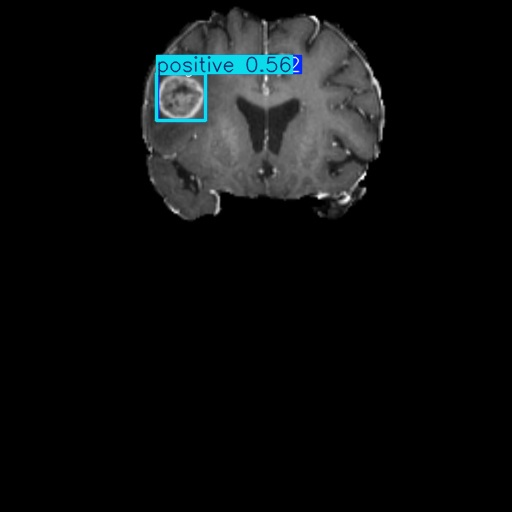



image 1/1 /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/images/test/00064_170.jpg: 640x640 1 negative, 15.2ms

Speed: 1.5ms preprocess, 15.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


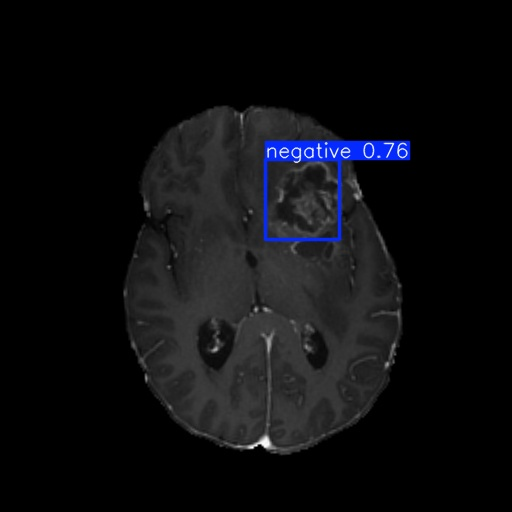



image 1/1 /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/images/test/00081_98.jpg: 640x640 1 negative, 1 positive, 15.3ms

Speed: 1.8ms preprocess, 15.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


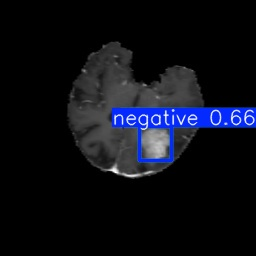

In [15]:
# Path to your trained model and test images directory
model_v1_path = 'runs/detect/train/weights/best.pt'
test_images_dir = 'dataset/images/test'

# Load the YOLO model
model_v1 = YOLO(model_v1_path)

# Function to display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)  # List all images in the directory
    sample_images = random.sample(images, num_images)  # Randomly select a few images
    save_dir = 'runs/detect/exp'  # Directory to save the results
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)  # Full path to the image
        results = model(image_path)  # Run the model on the image

        for result in results:
            # Save the result image with bounding boxes
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))  # Display the result image

# Display test images with detections
print("Displaying results from the brain tumor detection model:")
display_results(model_v1, test_images_dir)

### Validate the Model

In [16]:

# Define the path to the trained model's weights
weights_path = 'runs/detect/train/weights/best.pt'

# Check if the weights file exists before running the YOLO validation command
if os.path.exists(weights_path):
    # Run YOLO validation using the model and dataset paths
    !yolo task=detect mode=val model={weights_path} data=dataset/fixed_path.yaml
else:
    # Print an error message if the weights file is not found
    print(f"Weights file not found at {weights_path}. Please check the training process or path.")

Ultralytics YOLOv8.2.98 🚀 Python-3.9.19 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3694MiB)

YOLOv9s summary (fused): 486 layers, 7,167,862 parameters, 0 gradients, 26.7 GFLOPs

val: Scanning /home/sinem/Desktop/YOLOvX/projects/Brain_Tumor_detecion/dataset/l

                 Class     Images  Instances      Box(P          R      mAP50  m

                   all        175        184      0.623      0.839      0.784      0.595

              negative         81         85      0.627      0.859       0.79      0.601

              positive         94         99      0.619      0.819      0.779      0.588

Speed: 0.7ms preprocess, 15.6ms inference, 0.0ms loss, 0.5ms postprocess per image

Results saved to runs/detect/val

💡 Learn more at https://docs.ultralytics.com/modes/val


### Deploying the Custom Model on YOLOvX App for Real-time Inference
Once you are satisfied with the model performance you can now simply download the model from Output directory and upload it to the YOLOvX App. Now simply RUN

### Now we can go back to:


https://community.yolovx.com/t/experiment-3-brain-tumor-detection-on-yolovx-app/50/2